In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os

# Load dataset
file_path = os.path.join(os.path.dirname(os.getcwd()), "dataset", "vgsales.csv")
df = pd.read_csv(file_path)

# Filter data up to 2016 and handle missing values
df = df[df['Year'] <= 2016]
df = df.dropna(subset=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'])

# Selecting relevant columns for clustering
sales_data = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
scaler = StandardScaler()
sales_scaled = scaler.fit_transform(sales_data)

# Function to calculate Sessa Empirical Estimator
def sessa_estimator(data, max_k):
    ratios = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        within_cluster_var = kmeans.inertia_
        between_cluster_var = np.sum((kmeans.cluster_centers_ - np.mean(data, axis=0)) ** 2)
        ratios.append(between_cluster_var / within_cluster_var)
    return ratios

# Determine optimal number of clusters using Sessa Estimator
max_k = 10
sessa_ratios = sessa_estimator(sales_scaled, max_k)
optimal_k_sessa = np.argmax(sessa_ratios) + 1  # Add 1 because k starts at 1

# Apply K-Means Clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k_sessa, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(sales_scaled)

# Validate clusters using Silhouette Score
silhouette_avg = silhouette_score(sales_scaled, df['Cluster'])

# Analyze cluster characteristics
cluster_means = df.groupby('Cluster')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].mean()

# Assigning meaningful labels based on sales trends
cluster_labels = {}
avg_sales = cluster_means['Global_Sales'].sort_values()
for i, cluster_id in enumerate(avg_sales.index):
    if i == 0:
        cluster_labels[cluster_id] = "Low Sales"
    elif i == 1:
        cluster_labels[cluster_id] = "Moderate Sales"
    elif i == 2:
        cluster_labels[cluster_id] = "High Sales"
    else:
        cluster_labels[cluster_id] = "Blockbuster Hits"
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

Optimal k using Sessa Estimator: 10


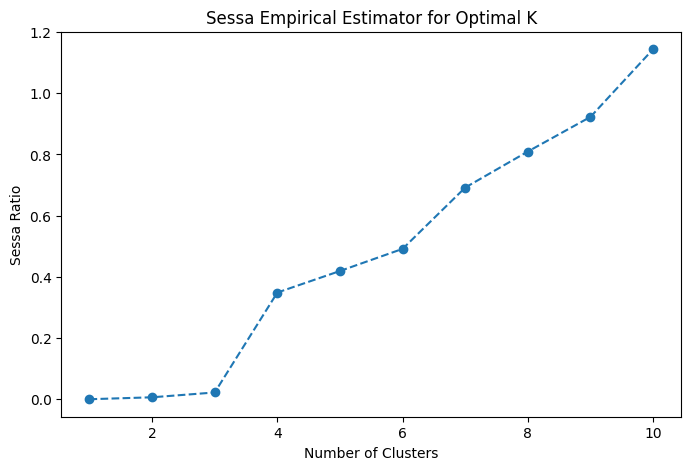

In [35]:
# Plot Sessa Ratios
print(f"Optimal k using Sessa Estimator: {optimal_k_sessa}")
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), sessa_ratios, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Sessa Ratio')
plt.title('Sessa Empirical Estimator for Optimal K')
plt.savefig('sessa_ratios.png', bbox_inches='tight')  # Save plot
plt.show()

This line plot visualizes the Sessa Ratio for different numbers of clusters (*K*).

- The X-axis represents the number of clusters (*K*), ranging from 1 to 10.

- The Y-axis represents the Sessa Ratio, which measures how well-seperated the clusters are.

- The peak of the curve indicates the optimal number of clusters (*K*), as it suggests the best trade-off between within-cluster compactness and between-cluster seperation.

The Sessa Empirical Estimator helps determine the best number of clusters (*K*) in K-means without using the traditional **Elbow Method** or **Silhouette Score** alone. This ensures better-defined clusters, improving the interpretability of reuslts.

### **Key Insights** ###

- The optimal *K* is found at the the peak of the curve.

- A high Sessa Ratio means clusters are well-seperated with minimal overlap.

- If the ratio increases consistently, it may indicate that more clusters are needed, but too many clusters can lead to *overfitting*.

Silhouette Score for optimal k: 0.65


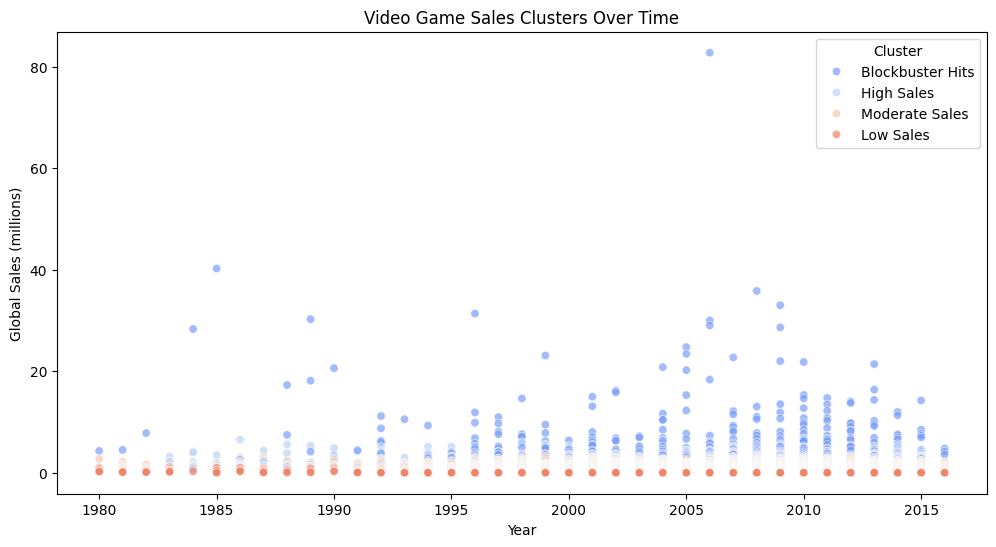

In [36]:
# Visualization of clusters
print(f"Silhouette Score for optimal k: {silhouette_avg:.2f}")
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['Year'], y=df['Global_Sales'], hue=df['Cluster_Label'], palette='coolwarm', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.title('Video Game Sales Clusters Over Time')
plt.legend(title='Cluster')
plt.savefig('sales_clusters_over_time.png', bbox_inches='tight')  # Save plot
plt.show()

This is a scatter plot of video game sales trends, with each game assigned to a K-means cluster.

- The X-axis represents the *Year* (release date of games).

- The Y-axis represents *Global Sales* (in millions).

Each point (game) is colored based on its assigned K-means cluster:

- Low Sales (e.g., small indie titles)
- Moderate Sales
- High Sales
- Blockbuster Hits (e.g., Pokemon, GTA, Call of Duty)

The purpose is to analyze sales trends across different years using K-means clustering. By detecting sales trends and market shifts over time we can identify patterns in blockbuster games, including which years had more top-selling titles.

### **Key Insights** ### 

- More blockbuster games appear in certain years, indicating strong industry grwoth in those periods.

- Older games generally have lower sales, but some remain top sellers due to franchise success.

- The presence of consistent high-sales clusters suggests game industry patterns where AAA (triple A companies) franchies dominate certain periods.

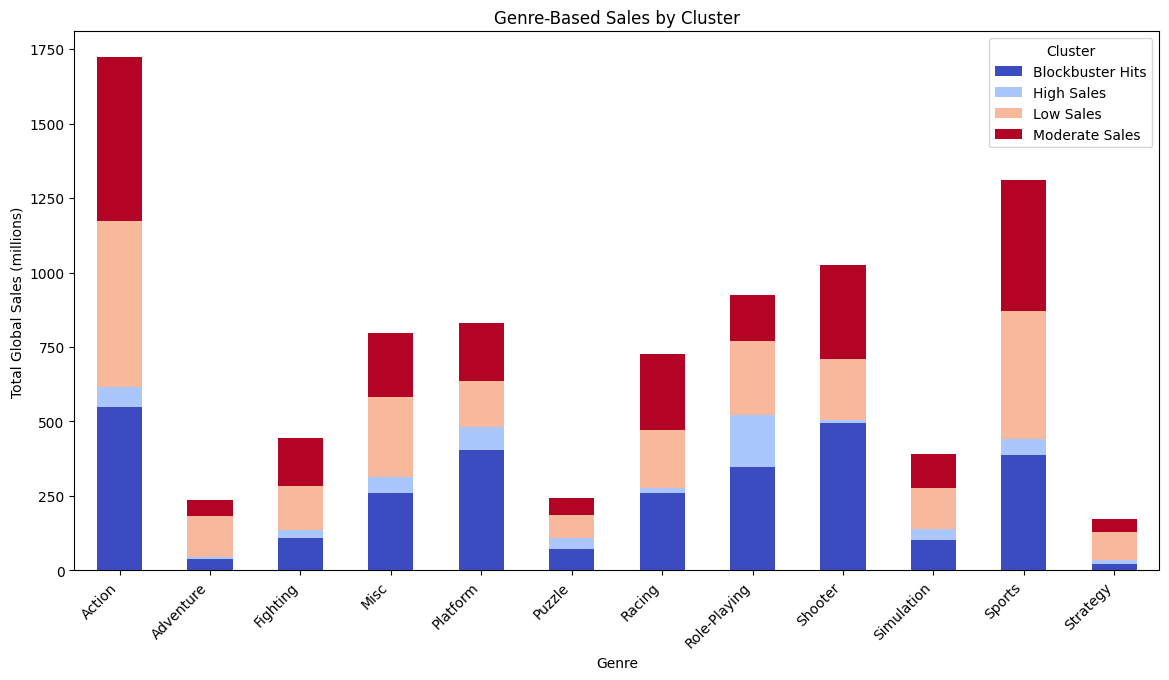

In [37]:
# Genre-based Clustering Visualization
genre_sales = df.groupby(['Genre', 'Cluster_Label'])['Global_Sales'].sum().unstack()
genre_sales.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='coolwarm')
plt.xlabel('Genre')
plt.ylabel('Total Global Sales (millions)')
plt.title('Genre-Based Sales by Cluster')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.savefig('genre_based_sales.png', bbox_inches='tight')  # Save plot
plt.show()

The stacked bar chart shows the total global sales per genre, grouped by their assigned K-means cluster.

- The X-axis represents different video game genres (e.g., Action, RPG, etc.).

- The Y-axis represents total global sales (in millions).

Each stacked section represents a sales cluster:

- Low Sales (bottom section)
- Moderate Sales
- High Sales
- Blockbuster Hits (top section)

This is to see which genres tend to have top-selling games. By identifying patterns in the game industry regarding what types of games perform well, with this we can understand whether genres are more likely to dominate sales categories.

### **Key Insights** ###

- Action, Shooter and Sports games dominate the Blockbuster Hits category, meaning these genres have historically produced the most top-selling games.

- Strategy, Puzzle, and Adventure games mostly fall in the lower sales clusters, suggesting they have more niche audiences.

- RPGs and Fighting games show a mixed distribution, meaning some franchises (e.g., Pokemon, Final Fantasy) become hits, while others remain in moderate sales.

### **Final Insights** ###

In [38]:
# Generate insights
print(f"Total number of games analyzed: {df.shape[0]}")
print(f"Optimal number of clusters: {optimal_k_sessa}")
print(f"Silhouette Score (cluster quality): {silhouette_avg:.2f}")
print("\nCluster Distribution:")
print(df['Cluster_Label'].value_counts().to_string())
print("\nTop Genres in Blockbuster Hits:")
print(df[df['Cluster_Label'] == 'Blockbuster Hits']['Genre'].value_counts().to_string())

Total number of games analyzed: 16323
Optimal number of clusters: 10
Silhouette Score (cluster quality): 0.65

Cluster Distribution:
Cluster_Label
Low Sales           13654
Moderate Sales       1888
Blockbuster Hits      485
High Sales            296

Top Genres in Blockbuster Hits:
Genre
Action          106
Shooter          80
Sports           59
Platform         51
Role-Playing     47
Misc             42
Racing           37
Fighting         25
Simulation       17
Puzzle            8
Adventure         8
Strategy          5
